<a href="https://colab.research.google.com/github/pablillo77/nlp_and_deep_learning/blob/main/DS_NLP_DeepLearning_Final_Pablo_Gim%C3%A9nez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> 🎬 Introduction 🎬</b></div>

## Presentation ##
The present project is based on a Kaggle dataset about BBC articles. The objective is to train and produce an algorithm for accurate news classification into five categories, that could yield commericial applications, customizing user engagement and giving insights for targeted audiences.

## Audience ##

This includes both readers seeking relevant content and businesses interested in market research, who could use categorized news for industry insights.

## Comercial Context ##

Personalized content delivery could improve user satisfaction and time spent on the platform. The classified data could also be valuable to marketing advertisers for audience targeting.

## Key Hypotheses and Questions ##

- Effective categorization and personalized news recommendations enhance reader engagement and retention.
- How the categories are distributed?
- Can we predict categories in new content?

## Objectives ##

- Produce an accurate classification model using LSTM and or RNN.
- Acquire category-based insights.
- Set the bases for future work on trending category predictions.





<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Preliminary data cleaning 🧹</b></div>

 </b></div>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>⏳Libraries imports and data upload⏳
 </b></div>

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import random


from collections import Counter
from wordcloud import WordCloud

# Sklearn mainly for model evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


# Tensorflow for creating and LSTM model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
#dataset load from github

url = 'https://raw.githubusercontent.com/pablillo77/nlp_and_deep_learning/refs/heads/main/bbc_text_cls.csv'
df = pd.read_csv(url)
df.shape

(2225, 2)

In [3]:
#Some quick checks

pd.set_option('display.max_colwidth',None)
print("Data shape: ",df.shape)
print("Data types: ",df.dtypes)
df.sample(2)

Data shape:  (2225, 2)
Data types:  text      object
labels    object
dtype: object


,text,labels
1077,"Anti-terror plan faces first test\n\nPlans to allow Home Secretary Charles Clarke to place terror suspects under house arrest without trial are set for their first real test in Parliament.\n\nTories, Lib Dems and some Labour MPs are poised to vote against the plans. Mr Clarke says the powers are needed to counter terror threats. Opponents say only judges, not politicians, should be able to order detention of UK citizens. The government is expected to win Wednesday's vote in the Commons, but faces a battle in the House of Lords.\n\nThe Prevention of Terrorism Bill was published on Tuesday. It proposes ""control orders"", which would mean house arrest in the most serious cases, and curfews, electronic tagging and limits on telephone and internet access for other suspects.\n\nThe two opposition parties are particularly worried that the control orders would initially be imposed on the say-so of the home secretary, rather than a judge. Tory shadow home secretary David Davis warned of the potential for miscarriages of justice, like the Guildford Four - for which Tony Blair recently apologised - as a result of the pressure on politicians to lock up terror suspects. ""Those pressures would be much more for a politician than they would on a judge and that's why we have serious concerns abut that approach,"" he told BBC Radio 4's Today programme.\n\nMr Clarke says he does not intend to use the house arrest powers now - even for the 11 current terror detainees. He also said that any decision he made would be reviewed by a judge within seven days. The foreign terror suspects currently detained are mostly held at London's Belmarsh prison. They are held under laws which the Law Lords have ruled break human rights rules - and which are due to expire on 14 March.\n\nThe new powers, designed to replace the existing laws and meet the Law Lords' concerns, would apply to British as well as foreign terror suspects. Critics say that giving politicians the power to deprive UK citizens of their freedom is the biggest attack on civil liberties for 300 years. Opposition MPs are also angry they will have only two days - Wednesday and next Monday - to debate the new plans before they pass to the House of Lords. But the government says the existing powers run out soon so must be replaced urgently.\n\nIn a rare move, the Tories and Lib Dems have jointly tabled a motion opposing the new bill, saying the house arrest plans are ""excessive"". It argues decisions should be taken on a higher standard of proof and the plan ""wrongly infringes the right to liberty"" by failing to bring terrorists to trial where there is evidence. Mr Davis told Today: ""It gives a minister, for the first time in modern history, the right to detain without trial, without showing the evidence and indeed, in some respects, almost the allegation against the individual concerned.""\n\nHe questioned why there was ""such a rush"" to introduce the legislation when Mr Clarke had indicated he was not planning to use the house arrest powers straight away. Liberal Democrat home affairs spokesman Mark Oaten said: ""We believe it should be the judge that takes decisions, not politicians."" Mr Clarke said the security services and police backed his measures and it would be ""rash and negligent"" to ignore their advice. Nobody should doubt that terrorists at home and abroad wanted to attack the UK and its interests, he argued.",politics
1815,"Safin relieved at Aussie recovery\n\nMarat Safin admitted he thought he was suffering another Australian Open final nightmare when he lost the opening set to Lleyton Hewitt.\n\nThe Russian, who lost the 2002 and 2004 finals, fought back brilliantly to win 1-6 6-3 6-4 6-4. ""I was nervous and I couldn't play tennis,"" said Safin. ""He started really well. He wasn't as nervous as I was because I was thinking of the two finals that I played and wasn't successful."" He added: ""You really have to deal with the pressure because normally it neve

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* We can appreciate the dataset has 2 columns, text and labels, consiting of 2225 entries. The data types are objects, "text" will be converted to string for further processing, and the labels will be encoded.
* In the random sample we see numbers, speciall chars such as new line characters that do not add value to the categorization, stop words and capital letters.

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧹 Data preliminary cleanup 🧹</b></div>

In [4]:
df['text'] = df['text'].astype(str)	 # Convert to string before regex
df['text'] = df['text'].str.lower() # Conversion to lowercase

df['text'] = (
    df['text']
    .str.replace(r'\d+', '', regex=True)           # Remove digits
    .str.replace(r'[^\w\s]', '', regex=True)        # Remove special characters except for word chars and whitespace
    .str.replace(r'\n', ' ', regex=True)            # Replace newlines with space
    .str.replace(r'\\', '', regex=True)             # Remove any remaining backslashes
    .str.replace(r'"', '', regex=True)              # Remove double quotes
    .str.strip()                                    # Trim leading/trailing whitespace
)




<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🔎 Exploratory Data Analysis (EDA).🔎</b></div>

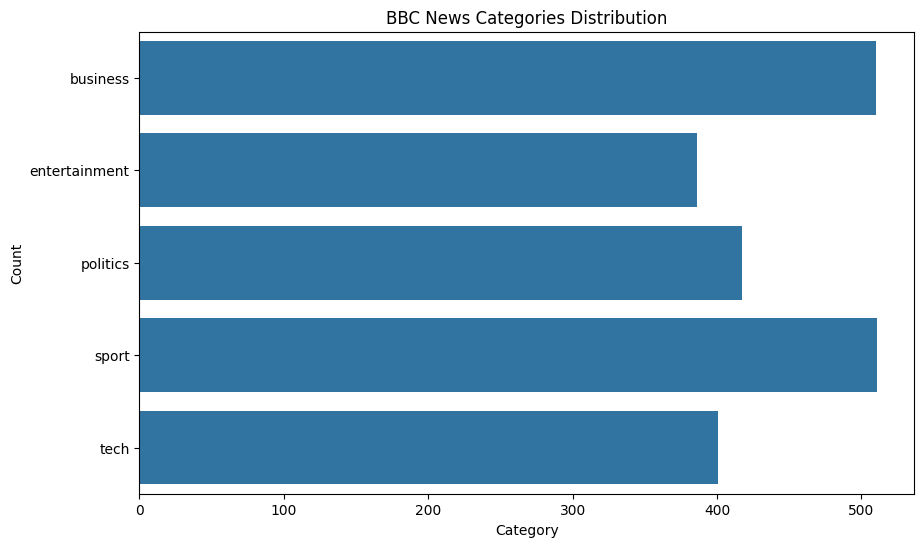

In [5]:
# Check categories distribution

plt.figure(figsize=(10, 6))
sns.countplot(y='labels', data=df)
plt.title(f'BBC News Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


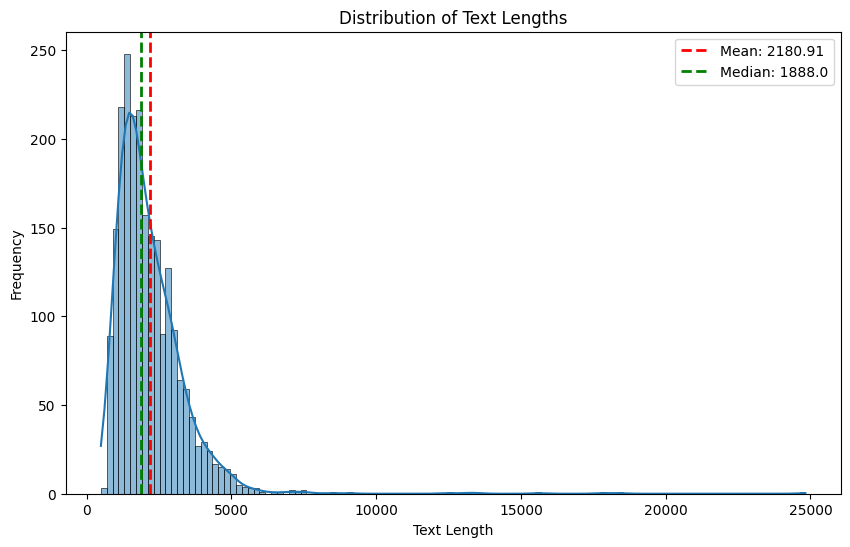

In [6]:
# Checking Text lenghts

df['text_length'] = df['text'].apply(len) # create a new column

mean_length = df['text_length'].mean()
median_length = df['text_length'].median()

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_length}')

plt.legend()
plt.show()

In [7]:
# Find the longest text element and its length

longest_text = df['text'].iloc[df['text'].str.len().idxmax()]
longest_text_length = len(longest_text)

print(f"Longest text element:\n{longest_text}\n")
print(f"Character count: {longest_text_length}")

Longest text element:
terror powers expose tyranny  the lord chancellor has defended government plans to introduce control orders to keep foreign and british terrorist suspects under house arrest where there isnt enough evidence to put them on trial  lord falconer insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties but thriller writer frederick forsyth tells bbc news of his personal response to the move    there is a mortal danger aimed at the heart of britain or so says home secretary charles clarke my reaction so what it is not that i am cynical or just do not care i care about this country very much  but in the  years that i have been alive there has not been one hour of one day of one month of one year when there has not been a threat aimed at us my point is the british have always coped without becoming a dictatorship we have coped with fear without becoming a st

In [8]:
# Stopwords removal

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)


df['text']=df['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


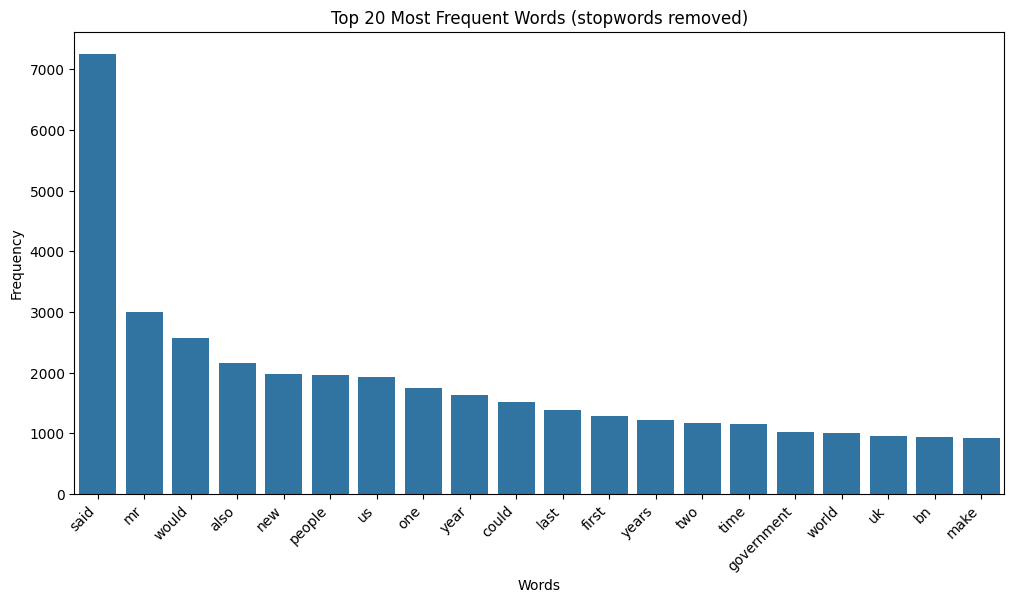

In [9]:
# Counting most frequent words

word_counts = Counter(" ".join(df['text']).split()) #from collections lib
top_20_words = word_counts.most_common(20)

# Extract words and counts for plotting

words, counts = zip(*top_20_words)

# Create the countplot

plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words (stopwords removed)')
plt.show()

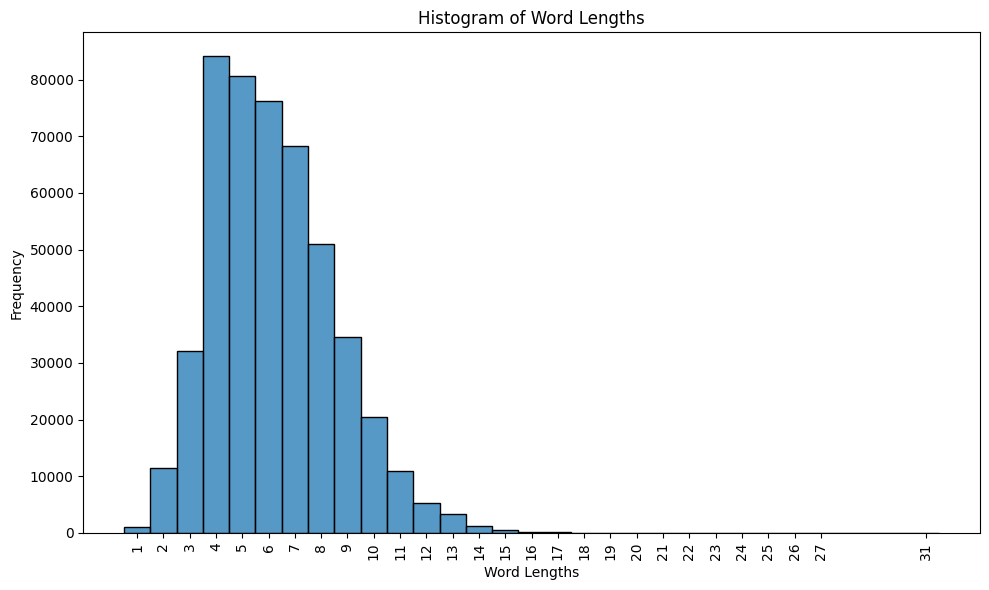

In [10]:
# Words lengths histogram

word_lengths = []
for text in df['text']:
    words = text.split()
    for word in words:
        word_lengths.append(len(word))

unique_word_lengths = sorted(list(set(word_lengths)))

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, discrete=True)
plt.xticks(unique_word_lengths, rotation=90)
plt.xlabel('Word Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Word Lengths')
plt.tight_layout()
plt.show()

In [11]:
# Unique word count analysis, for later use in creating a model

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

# Fit the text column into a BoW matrix
matrix_bow = vectorizer.fit_transform(df["text"])

# Generated vocabulary
vocabulary  = vectorizer.get_feature_names_out()

unique_word_count = len(np.unique(vocabulary ))

print(f"Number of unique words: {unique_word_count}")

Number of unique words: 31386


In [12]:
# N-grams analysis

from nltk import ngrams


def analyze_ngrams(df, column_name, n=2):
    all_ngrams = []
    for text in df[column_name]:
        # Tokenize the text
        tokens = nltk.word_tokenize(str(text).lower())  # Convert to lowercase

        # Generate n-grams
        text_ngrams = list(ngrams(tokens, n))

        # Extend the list of all n-grams
        all_ngrams.extend(text_ngrams)

    # Count the frequency of each n-gram
    ngram_counts = Counter(all_ngrams)

    # Print or return the most frequent n-grams
    print(f"Top 10 most frequent {n}-grams:\n")
    for ngram, count in ngram_counts.most_common(10):
        print(f"{ngram}: {count}")


analyze_ngrams(df, 'text', n=2)  # Analyze bigrams
print("\n")
analyze_ngrams(df, 'text', n=3)  # Analyze trigrams
print("\n")
analyze_ngrams(df, 'text', n=4)  # Analyze 4grams

Top 10 most frequent 2-grams:

('last', 'year'): 384
('said', 'mr'): 359
('told', 'bbc'): 348
('mr', 'blair'): 296
('prime', 'minister'): 274
('mr', 'brown'): 214
('chief', 'executive'): 198
('said', 'would'): 192
('bbc', 'news'): 178
('general', 'election'): 172


Top 10 most frequent 3-grams:

('told', 'bbc', 'news'): 147
('bbc', 'news', 'website'): 94
('told', 'bbc', 'radio'): 76
('leader', 'michael', 'howard'): 55
('mr', 'blair', 'said'): 54
('million', 'dollar', 'baby'): 50
('radio', 'today', 'programme'): 49
('told', 'bbc', 'sport'): 48
('bbc', 'radio', 'today'): 47
('tory', 'leader', 'michael'): 41


Top 10 most frequent 4-grams:

('told', 'bbc', 'news', 'website'): 77
('bbc', 'radio', 'today', 'programme'): 44
('told', 'bbc', 'radio', 'today'): 39
('tory', 'leader', 'michael', 'howard'): 38
('prime', 'minister', 'tony', 'blair'): 26
('foreign', 'secretary', 'jack', 'straw'): 22
('home', 'secretary', 'charles', 'clarke'): 21
('bbc', 'radio', 'five', 'live'): 18
('shadow', 'chanc

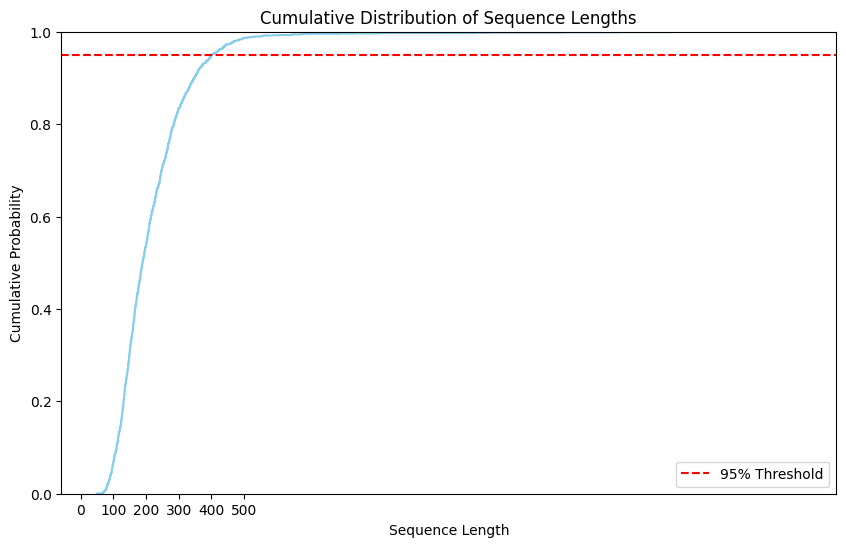

In [13]:
#Study the distribution of sequence lengths

# Prepare text data
texts = df['text'].values

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Create a DataFrame for easier analysis
lengths_df = pd.DataFrame(sequence_lengths, columns=['length'])

# Plot the cumulative distribution of sequence lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=lengths_df, x='length', color='skyblue')
plt.xlabel('Sequence Length')
plt.xticks(range(0, 600, 100))
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Sequence Lengths')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()



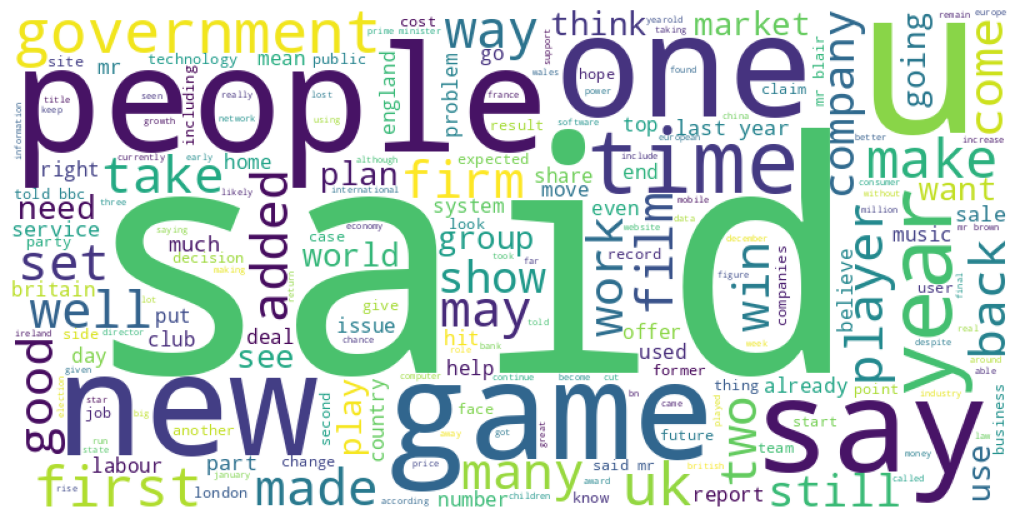

In [14]:
# Create the word cloud

text = " ".join(text for text in df['text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* The categories (labels) have a good classes balance in the dataset.
* Text lenght analysis, shows a distribution with a mean value of 218 characters, the longest text has 24829.
* Most frequent words are "said" and "mr", "would", consistent with the reporting tone and style of a news channel.
* The word lenghts analysis, indicates that having removed the stopwords (usually words of 2 or 3 letters if language is English) the next most frequent lengths are 4 and 5 letters long. Again there is agreement with the language used.
* We found 31386 different and unique words.
* N-Grams study shows context also in agreemnent with the reporting style of a news channel. "last year", "told BBC news" and "told BBC news website" are the most frequent for bigrams, trigrams and four-grams.
* Sequence Length cumulative distribution, indicates that selecting in further processing 300 as sequence length, would cover roughly 95% of length cases.

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🧠 Models creation and optimization 🧠</b></div>

## <b>Functions definitions</b>

In [15]:
# Define a plotting function for losses curves
# Input is the model

def plot_training_history(model):
  plt.figure(figsize=(10, 6))
  plt.plot(model.history.history['loss'], label='Training Loss')
  plt.plot(model.history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

In [16]:
# For predicting on test data and to calculate metrics

def calculate_metrics(model, X_test_padded, y_test):
  y_test_predictions = model.predict(X_test_padded)
  y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

  accuracy = accuracy_score(y_test, y_test_pred_classes)
  precision = precision_score(y_test, y_test_pred_classes, average='macro')
  recall = recall_score(y_test, y_test_pred_classes, average='macro')
  f1 = f1_score(y_test, y_test_pred_classes, average='macro')

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

## <b>Feature selection and encoding</b>

In [17]:
# Prepare text data and labels
X = df['text'].values
y = df['labels'].values #target variable

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



## <b>Data split, tokenization and padding</b>

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

# Tokenization and padding
max_words = 20000  # Number of unique words to use
max_length = 300  # Maximum length of input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

## <b>Building, compiling and testing model 1</b>

In [ ]:
# LSTM model

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Training the model 1
model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.2758 - loss: 1.5733 - val_accuracy: 0.5028 - val_loss: 1.1366
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.5951 - loss: 0.9576 - val_accuracy: 0.4663 - val_loss: 1.1869
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7071 - loss: 0.7708 - val_accuracy: 0.8933 - val_loss: 0.5309
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 381ms/step - accuracy: 0.9652 - loss: 0.2704 - val_accuracy: 0.9354 - val_loss: 0.2782
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9859 - loss: 0.1290 - val_accuracy: 0.9213 - val_loss: 0.3004
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - accuracy: 0.9893 - loss: 0.0752 - val_accuracy: 0.9185 - val_loss: 0.2939
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.9982 - loss: 0.0384 - val_accuracy: 0.9522 - val_loss: 0.1645
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.9983 - loss: 0.0281 - val_accu

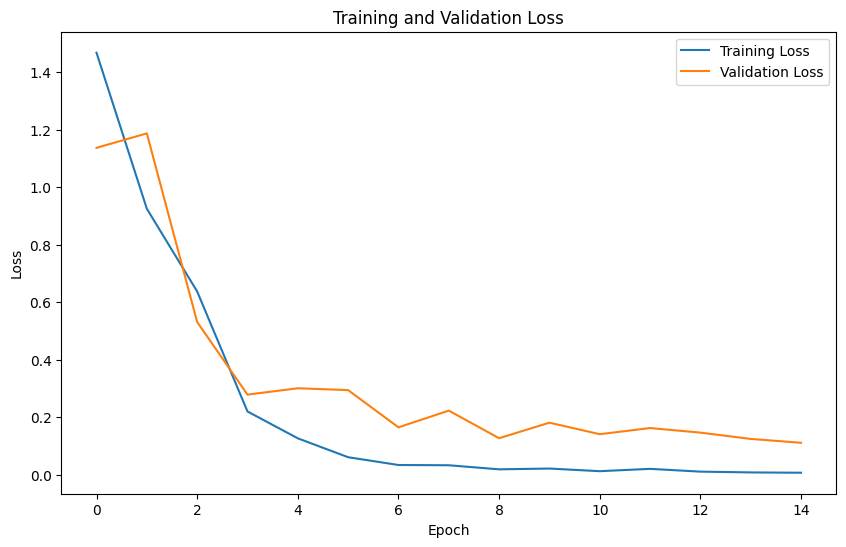

In [ ]:
plot_training_history(model)

In [ ]:
# Calculate model metrics

calculate_metrics(model, X_test_padded, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


{'accuracy': 0.9393258426966292,
 'precision': 0.9391349447388422,
 'recall': 0.9339026113878045,
 'f1': 0.9362639088266705}

In [ ]:
# Predicting on test data
y_test_predictions = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_predictions, axis=1)

# Calculate metrics for test data
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


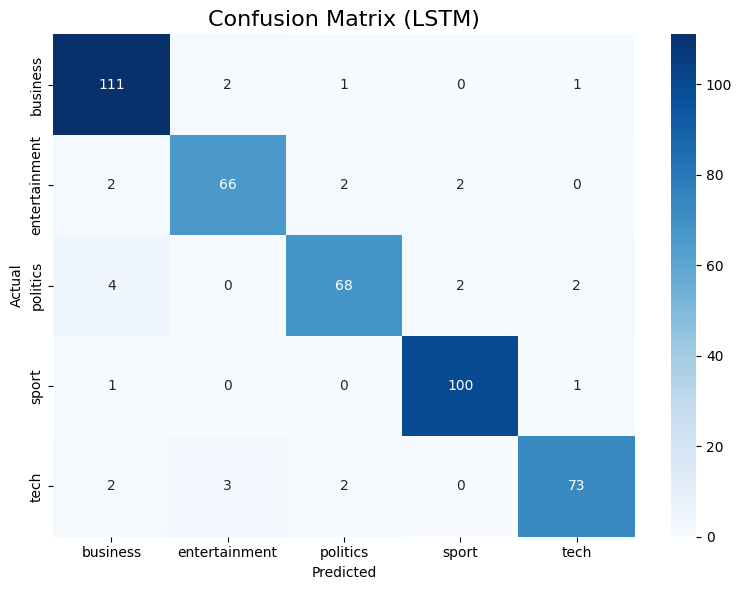

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
ax.xaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.yaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* The model shows very good fit, validation loss flattens or descends slightly after epoch 3.
* Training loss keeps descending together with validation loss at the begining, we could cut the training earlier saving training time.
* Confusion matrix and metrics show a very good balance between precision and recall.

## <b>Building, compiling and testing model 2</b>

In [ ]:
# model 2, hybrid between LSTM and GRU to capture short and long paterns

from tensorflow.keras.layers import GRU

model2 = Sequential()
model2.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(GRU(32))
model2.add(Dropout(0.2))
model2.add(Dense(len(label_encoder.classes_), activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model2.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 507ms/step - accuracy: 0.2754 - loss: 1.5816 - val_accuracy: 0.5843 - val_loss: 1.0442
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 424ms/step - accuracy: 0.7309 - loss: 0.7350 - val_accuracy: 0.9242 - val_loss: 0.2322
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.9846 - loss: 0.0937 - val_accuracy: 0.9410 - val_loss: 0.1753
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accuracy: 0.9974 - loss: 0.0318 - val_accuracy: 0.9157 - val_loss: 0.2662
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.9988 - loss: 0.0165 - val_accuracy: 0.9298 - val_loss: 0.2249
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9326 - val_loss: 0.2361
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9522 - val_loss: 0.1728
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 572ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accu

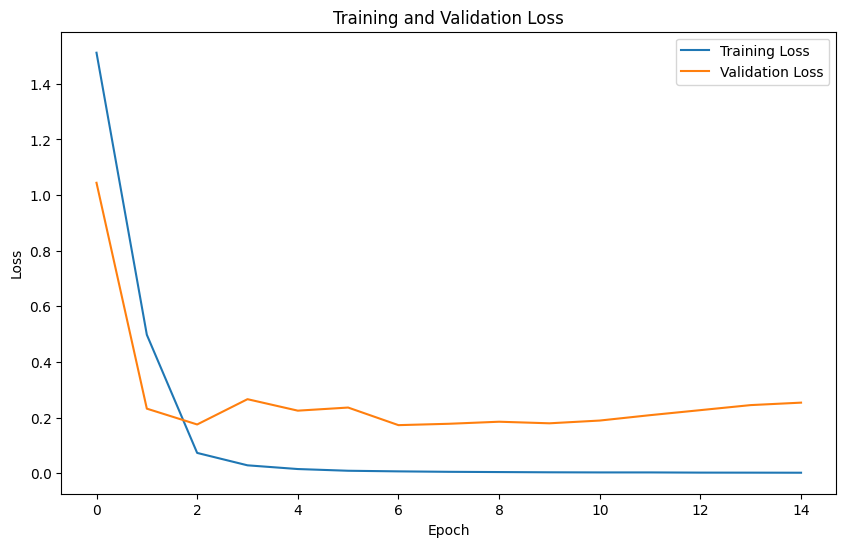

In [ ]:
plot_training_history(model2)

In [ ]:
calculate_metrics(model2, X_test_padded, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


{'accuracy': 0.9303370786516854,
 'precision': 0.9286712581261171,
 'recall': 0.9268753458667982,
 'f1': 0.9275102642646502}

In [ ]:
# Predicting on test data with model 2

y_test_predictions = model2.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_predictions, axis=1)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


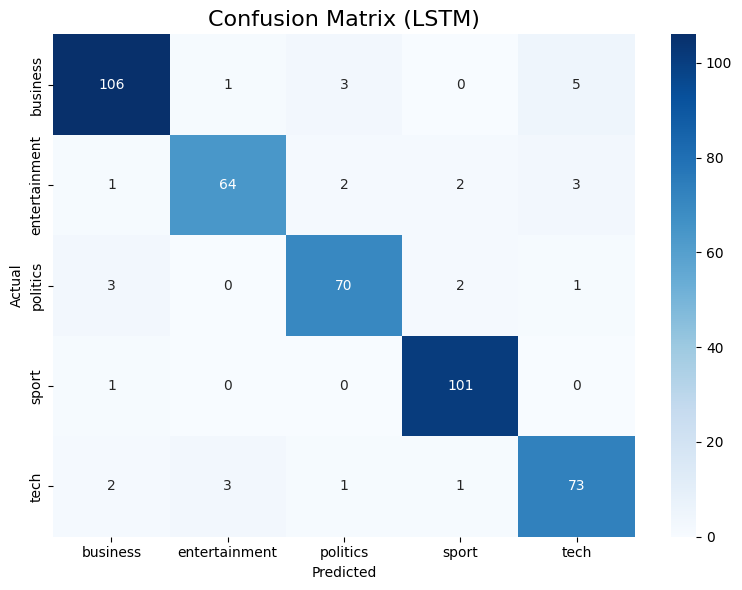

In [ ]:
# Generate confusion matrix

cm = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
ax.xaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.yaxis.set_ticklabels(label_encoder.classes_, fontsize=10)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="lefAt"><font color=brown>💬 Insight:</font></h3>

* No significant improvement over model 1 was observed, in fact the overall performance of model 2 is sligthly inferior.

## <b>Additional random testing with selected model (1)</b>

In [ ]:
# Select 10 random indices from the test data
random_indices = random.sample(range(len(X_test)), 20)

# Loop through the selected indices
for index in random_indices:
    # Get the text and true label
    text = X_test.iloc[index]
    true_label = y_test[index]

    # Preprocess the text for prediction
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)

    # Predict the category
    prediction = model.predict(text_padded)
    predicted_label = np.argmax(prediction)

    # Decode the predicted label
    predicted_category = label_encoder.inverse_transform([predicted_label])[0]
    true_category = label_encoder.inverse_transform([true_label])[0]

    # Print the results
    print(f"Text: {text[:100]}...")  # Print the first 100 characters of the text
    print(f"Predicted Category: {predicted_category}")
    print(f"Actual Category: {true_category}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Text: euus seeking deal air dispute eu us agreed begin talks ending subsidies given aircraft makers eu tra...
Predicted Category: business
Actual Category: business
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Text: ford gains finance cars ford us car company reported higher fourth quarter fullyear profits thursday...
Predicted Category: business
Actual Category: business
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Text: rovers reject third ferguson bid blackburn rejected third bid rangers scotland captain barry ferguso...
Predicted Category: sport
Actual Category: sport
----------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Text: manchester wins labour conference labour party hol

# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Verdana;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>🎈 Conclusions and final comments 🎈</b></div>

<h3 align="lefAt"><font color=brown>💬 Main insights:</font></h3>

* News categories were accurately predicted, keeping great balance with recall, showing a low false positve rate and a low false negative rate too.
* High precision, 93%, indicates a good starting point for a predictive system that would preselect relevant content for the users.
* LSTM models were explored, several tests were done adjusting amount of layers, dropout to prevent overfitting, even adjusting learning rate till we reached the presented model.
* LSTM-GRU hybrid model showed no improvement, could save some computing time if deployed for production.
